In [ ]:
import pandas as pd 
import numpy as np 
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import seaborn as sns

In [ ]:
import pandas as pd

# Define the file path using a raw string literal
file_path = r'C:\Users\Admin\Downloads\data.parquet'

# Load the Parquet file into a DataFrame
data = pd.read_parquet(file_path)

data = data.between_time('09:15', '15:30').copy()
print(data.head(2000))

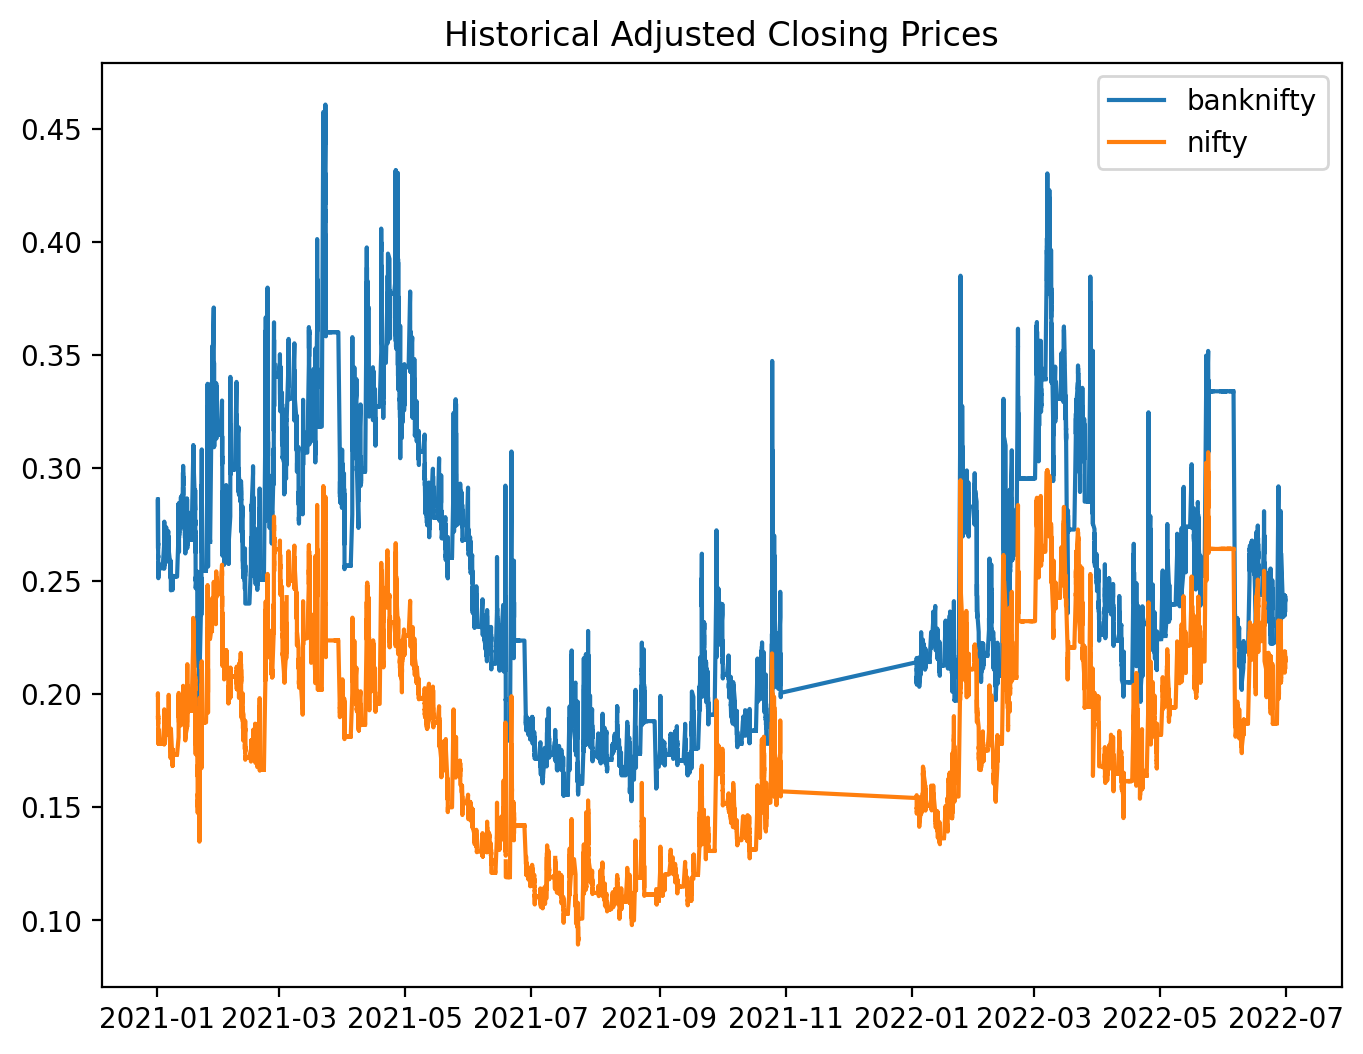

In [17]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=200)
plt.plot(data["banknifty"], label="banknifty")
plt.plot(data["nifty"], label="nifty")
plt.title('Historical Adjusted Closing Prices')
plt.legend()
plt.show()


In [8]:
data.isnull().sum()

banknifty    1500
nifty        2000
tte             0
dtype: int64

In [19]:
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
# Introduce `IterativeImputer()`
imp = IterativeImputer()
# Fit to your manipulated df
imp.fit(data)
# Transform and save the transformed data as a dataframe
data_filled = pd.DataFrame(imp.transform(data), columns = data.columns, index = data.index)
data_filled.isnull().sum()

banknifty    0
nifty        0
tte          0
dtype: int64

<Axes: >

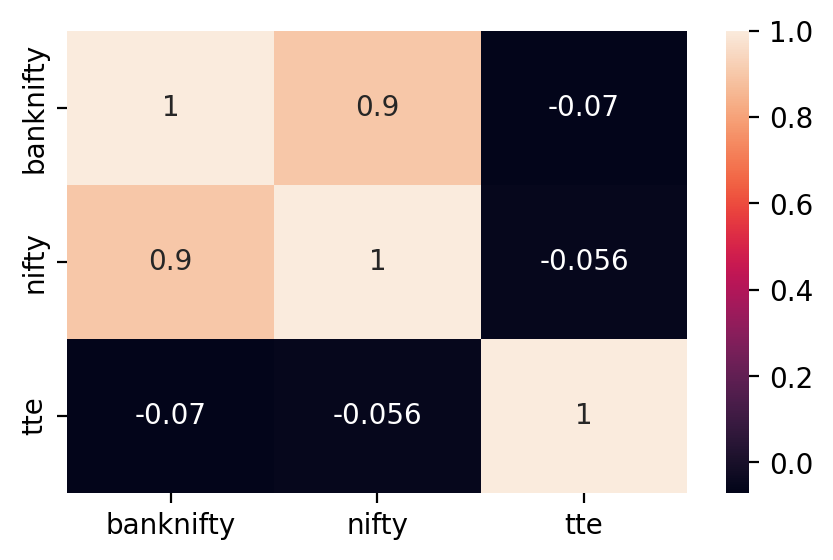

In [10]:
corr_matrix = data.corr()
corr_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 3), dpi=200)
sns.heatmap(corr_matrix, annot = True)

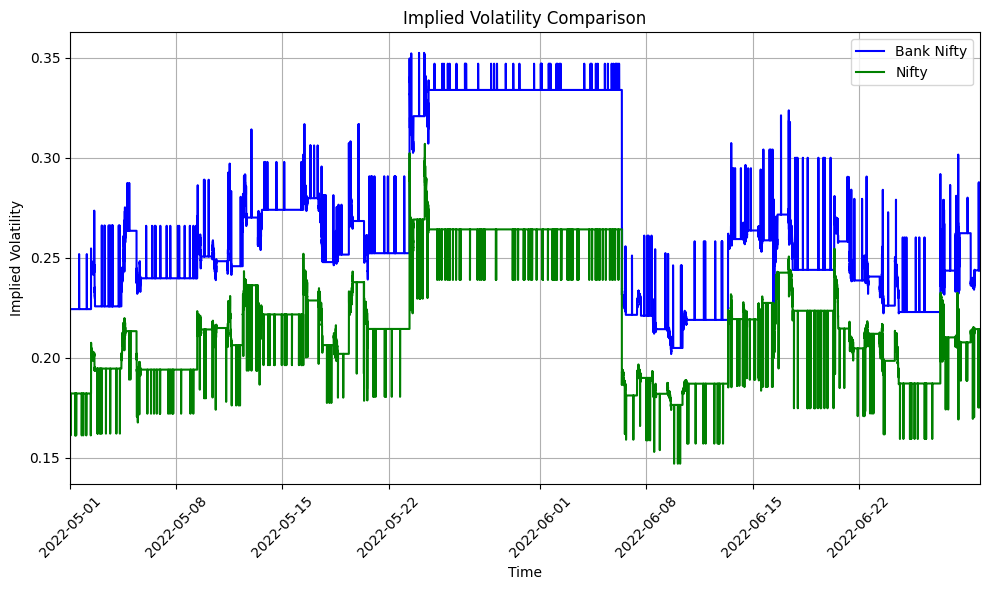

In [11]:


# Assume 'time' is not present, instead, we'll use the index as time
data.index = pd.to_datetime(data.index)  # Convert index to datetime if it's not already

# Specify the start and end dates for the duration you want to plot
start_date = pd.to_datetime('2022-05-01')  # Convert start date to datetime object
end_date = pd.to_datetime('2022-06-30')  # Convert end date to datetime object

# Filter the data for the specified duration
data_subset = data.loc[start_date:end_date]

# Plot the line chart
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot Bank Nifty implied volatility
plt.plot(data_subset.index, data_subset['banknifty'], label='Bank Nifty', color='blue', linestyle='-')

# Plot Nifty implied volatility
plt.plot(data_subset.index, data_subset['nifty'], label='Nifty', color='green', linestyle='-')

plt.title('Implied Volatility Comparison')
plt.xlabel('Time')
plt.ylabel('Implied Volatility')
plt.legend()  # Show legend

plt.grid(True)  # Add gridlines
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.xlim(start_date, end_date)

plt.tight_layout()  # Adjust layout to prevent overlap of labels
plt.show()


In [21]:
_, pvalue, _ = coint(data_filled['banknifty'],data_filled['nifty'])

if pvalue <0.05:
    print("The time series are cointegrated.", pvalue)
else:
    print("The time series are not cointegrated.")


The time series are cointegrated. 0.001342544299492575


We use the cointegration test for the trading model of z-score of the spread
Cointegration test: A technique used to find a potential correlation in a time series (long term) Determines if the spread between the two assets are constant over time
# Null Hypothesis: Spread between series are non-stationary
# Uses the augmented Engle-Granger two-step cointegration tet.


In [23]:
from scipy.stats import zscore

data_filled['spread'] = data_filled['banknifty'] - data_filled['nifty']
data_filled['z_score'] = zscore(data_filled['spread'])

data_filled.head()


,banknifty,nifty,tte,spread,z_score
time,,,,,
2021-01-01 09:15:00,0.286058,0.199729,27.0,0.086329,0.544640
2021-01-01 09:16:00,0.285381,0.200433,27.0,0.084948,0.492540
2021-01-01 09:17:00,0.284233,0.200004,27.0,0.084229,0.465385
2021-01-01 09:18:00,0.286104,0.199860,27.0,0.086244,0.541413
2021-01-01 09:19:00,0.285539,0.198951,27.0,0.086588,0.554415


In [26]:
data_filled['P/L'] = data_filled['spread'] * data_filled['tte'] ** 0.7


In [27]:
df= data_filled.copy()

In [28]:

# arbitrary thresholds for trading signals
long_threshold = -1.0
short_threshold = 1.0

# Initialize variables for tracking trades
in_trade = False
trade_type = None
entry_price = 0
entry_index = 0
exit_index = 0
pnl = 0

# Iterate through the data
for i in range(len(df)):
    # Check if we are in a trade and if it's time to exit
    if in_trade and (i - entry_index) >= 1875:
        pnl += (df.iloc[i]['P/L'] - entry_price) if trade_type == 'long' else (entry_price - df.iloc[i]['P/L'])
        in_trade = False
        exit_index = i
    
    # Check for entry signals
    if not in_trade:
        if df.iloc[i]['z_score'] < long_threshold:
            in_trade = True
            trade_type = 'long'
            entry_price = df.iloc[i]['P/L']
            entry_index = i
        elif df.iloc[i]['z_score'] > short_threshold:
            in_trade = True
            trade_type = 'short'
            entry_price = df.iloc[i]['P/L']
            entry_index = i

# Calculate final P/L if trade is still open
if in_trade:
    pnl += (df.iloc[exit_index]['P/L'] - entry_price) if trade_type == 'long' else (entry_price - df.iloc[exit_index]['P/L'])

print("Total P/L:", pnl)


Total P/L: 5.674162849221504


In [30]:
df2 = data_filled.copy()

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(data['spread'], order=(5,1,0))  # Example order, you may need to tune this
model_fit = model.fit()

# Forecast future spread values
forecast_steps = 5  # Adjust the number of steps ahead to forecast
forecast = model_fit.forecast(steps=forecast_steps)

# Generate trading signals based on forecasted spread values
trading_signals = []
for i in range(len(forecast)):
    if forecast[i] > 0:
        trading_signals.append('buy')  # Buy signal
    else:
        trading_signals.append('sell')  # Sell signal

# Calculate P/L based on trading signals
initial_capital = 1000000  # Initial capital in base currency (e.g., USD)
df2 = pd.DataFrame(index=data.index[-forecast_steps:], columns=['P/L'])
capital = initial_capital
for i, signal in enumerate(trading_signals):
    if signal == 'buy':
        df2.iloc[i]['P/L'] = data['spread'].iloc[-forecast_steps + i]  # Assuming buying at the current spread value
        capital -= data['spread'].iloc[-forecast_steps + i]  # Deducting buying cost from capital
    else:
        df2.iloc[i]['P/L'] = -data['spread'].iloc[-forecast_steps + i]  # Assuming selling at the current spread value
        capital += data['spread'].iloc[-forecast_steps + i]  # Adding selling proceeds to capital

# Calculate total P/L
total_pnl = df2['P/L'].sum()

print("Total P/L:", total_pnl)
